In [17]:
# Imports basics
import numpy as np
import h5py
import json
import setGPU
import sklearn
import corner
import os
import scipy
# Imports neural net tools
import itertools
import torch
import torch.nn as nn
from torch.autograd.variable import *
import torch.optim as optim
from fast_soft_sort.pytorch_ops import soft_rank
import matplotlib.pyplot as plt
import uproot
import torch
from torch.utils.data import DataLoader
from modeloss.pytorch import MoDeLoss
from util.loss import MSE, DiscoLoss
from util.model import Model
#, ProgressBar, Logger
from util.utils import DataSet, swish, get_class_weights, find_threshold
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [18]:
# Sets controllable values

particlesConsidered = 50
particlesPostCut = 50
entriesPerParticle = 4
eventDataLength = 9
decayTypeColumn = -1
#datapoints = None
modelName = "IN_FlatSamples_EighthQCDEighthSig_50particles_pTsdmassfilling_dRlimit08_ECF"


In [19]:
class simple_MLP(torch.nn.Module):
    def __init__(self,input_size=5,out_channels=2,act_out=True,nlayers=4,nhidden=50,batchnorm=True):
        super().__init__()
        self.bn  = torch.nn.BatchNorm1d(input_size).cuda()
        self.fc1 = torch.nn.Linear(input_size, 50, bias=False).cuda()
        self.ac1 = torch.nn.ReLU().cuda()
        self.dp1 = torch.nn.Dropout(p=0.2).cuda()
        self.fc2 = torch.nn.Linear(50, 30).cuda()
        self.ac2 = torch.nn.ReLU().cuda()
        self.fc3 = torch.nn.Linear(30, 10).cuda()
        self.ac3 = torch.nn.ReLU().cuda()
        self.fc4 = torch.nn.Linear(10, out_channels).cuda()
        self.output = torch.nn.Sigmoid().cuda()
        self.out_channels = out_channels
        self.act_out = act_out
        self.nlayers = nlayers
        self.runbatchnorm = batchnorm
        
    def forward(self, x):
        x = torch.flatten(x,start_dim=1)
        x = self.bn(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.output(x)
        return x

In [13]:
mode0 = MoDeLoss(bins=32,
    sbins=32,
    memory=False,
    background_label=0,
    background_only=True,
    power=2,
    order=0,
    lambd=None,
    max_slope=None,
    monotonic=False,
    eps=0.0001,
    dynamicbins=True,
    normalize=True,
    sign_func='tanh')

Extracting
Preparing Data
2972473
(2377978, 4, 50)
Selecting particlesPostCut


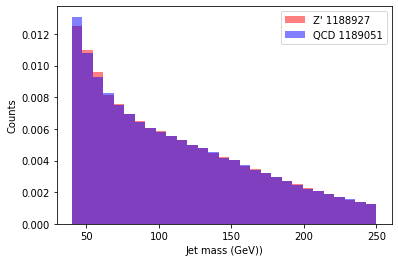

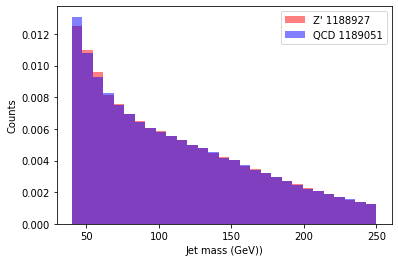

/tmp/ipykernel_41405/2990862208.py:147: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ax.hist(eventTrainingData[(jetMassTrainingData < 200.)&(trainingLabels[:,1].astype(bool),8)],color="b",bins=np.linspace(0.0,0.5,30),alpha=0.5,label=f"QCD {len(jetMassTrainingDataBkg)}",density=True)


ValueError: operands could not be broadcast together with shapes (2377978,) (2,) 

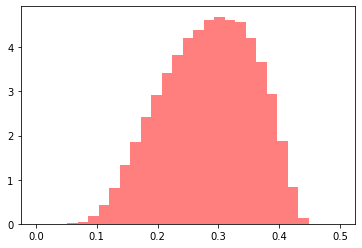

In [21]:
# Creates Training Data

# Opens files and reads data

print("Extracting")
weightMode = 500
msd_sig_min = 40.
msd_sig_max = 250.
loss_text=f"$\lambda_mode[0]\$ = {weightMode}"

label=f'mode0_{weightMode}lambdaMode0'
outdir = '/uscms_data/d3/jkrupa/flat/FlatSamples/plots/'+label
os.system(f'mkdir -p {outdir}')
fOne = h5py.File("/uscms_data/d3/eamoreno/FlatSamples/data/FullQCD_FullSig_Zqq_noFill_dRlimit08_50particlesordered_genMatched50_ECF_flatratio.h5", 'r')
totalData = fOne["deepDoubleQ"][:]

print("Preparing Data")

particleDataLength = particlesConsidered * entriesPerParticle

np.random.seed(42)
np.random.shuffle(totalData)
print(len(totalData))
#trainingDataLength = int(datapoints*0.8)
#validationDataLength = int(datapoints*0.1)

mask = [i>40. for i in totalData[:, 5]]
mask2 = []
for i in range(totalData.shape[0]):
    if totalData[i,-1]==0:
        mask2.append(True)
    else:
        mass = totalData[i,5]
        if (mass > msd_sig_min) and (mass < msd_sig_max):
            mask2.append(True)
        else:
            mask2.append(False)
            
tot_mask = mask and mask2

totalData = totalData[tot_mask]
datapoints = len(totalData)

#datapoints = min(sum(totalData[:,-1]==1), sum(totalData[:,-1]==0))
trainingDataLength = int(len(totalData)*0.8)
validationDataLength = int(len(totalData)*0.1)

labels = totalData[:, decayTypeColumn:]
particleData = totalData[:, eventDataLength:particleDataLength + eventDataLength]
eventData = totalData[:, :eventDataLength]
jetMassData = totalData[:, 5] #last entry in eventData (zero indexing)


######### Training Data ###############
eventTrainingData = np.array(eventData[0:trainingDataLength],dtype=np.float16)
jetMassTrainingData = np.array(jetMassData[0:trainingDataLength],dtype=np.float16)
particleTrainingData = np.transpose(
    particleData[0:trainingDataLength, ].reshape(trainingDataLength, 
                                                 entriesPerParticle, 
                                                 particlesConsidered),
                                                 axes=(0, 1, 2))

print(particleTrainingData.shape)
particleTrainingData = particleTrainingData.astype(np.float16)

trainingLabels = np.array([[i, 1-i] for i in labels[0:trainingDataLength]]).reshape((-1, 2))

torch.save(torch.Tensor(particleTrainingData),f"{outdir}/{label}_particleTrainingData.pt")
torch.save(torch.Tensor(jetMassTrainingData),f"{outdir}/{label}_jetMassTrainingData.pt")
torch.save(torch.Tensor(trainingLabels),f"{outdir}/{label}_trainingLabels.pt")

########## Validation Data ##########
eventValidationData = np.array(eventData[trainingDataLength:trainingDataLength + validationDataLength])
jetMassValidationData = np.array(jetMassData[trainingDataLength:trainingDataLength + validationDataLength])
particleValidationData = np.transpose(
    particleData[trainingDataLength:trainingDataLength + validationDataLength, ].reshape(validationDataLength,
                                                                                         entriesPerParticle,
                                                                                         particlesConsidered),
                                                                                         axes=(0, 1, 2))
validationLabels = np.array([[i, 1-i] for i in labels[trainingDataLength:trainingDataLength + validationDataLength]]).reshape((-1, 2))



########### Testing Data ############
eventValidationData = np.array(eventData[trainingDataLength + validationDataLength:])
particleTestData = np.transpose(particleData[trainingDataLength + validationDataLength:,].reshape(
    len(particleData) - trainingDataLength - validationDataLength, entriesPerParticle, particlesConsidered),
                                axes=(0, 1, 2))
testLabels = np.array(labels[trainingDataLength + validationDataLength:])


torch.save(torch.Tensor(particleTrainingData),f"{outdir}/{label}_particleTestingData.pt")
torch.save(torch.Tensor(jetMassTrainingData),f"{outdir}/{label}_jetMassTestingData.pt")
torch.save(torch.Tensor(trainingLabels),f"{outdir}/{label}_testingLabels.pt")


print('Selecting particlesPostCut')
particleTrainingData = particleTrainingData[:, :particlesPostCut]
particleValidationData = particleValidationData[:, :particlesPostCut]

particlesConsidered = particlesPostCut




# Separating signal and bkg arrays
particleTrainingDataSig = particleTrainingData[trainingLabels[:,0].astype(bool)]
particleTrainingDataBkg = particleTrainingData[trainingLabels[:,1].astype(bool)]
particleValidationDataSig = particleValidationData[validationLabels[:,0].astype(bool)]
particleValidationDataBkg = particleValidationData[validationLabels[:,1].astype(bool)]
particleTrainingLabelSig = trainingLabels[trainingLabels[:,0].astype(bool)]
particleTrainingLabelBkg = trainingLabels[trainingLabels[:,1].astype(bool)]

# Jet mass for correlation
jetMassTrainingDataSig = jetMassTrainingData[trainingLabels[:,0].astype(bool)]
jetMassTrainingDataBkg = jetMassTrainingData[trainingLabels[:,1].astype(bool)]
jetMassValidationDataSig = jetMassValidationData[validationLabels[:,0].astype(bool)]
jetMassValidationDataBkg = jetMassValidationData[validationLabels[:,1].astype(bool)]


fig,ax = plt.subplots()
ax.hist(jetMassTrainingDataSig,color="r",bins=np.linspace(40,250,30),alpha=0.5,label=f"Z' {len(jetMassTrainingDataSig)}",density=True)
ax.hist(jetMassTrainingDataBkg,color="b",bins=np.linspace(40,250,30),alpha=0.5,label=f"QCD {len(jetMassTrainingDataBkg)}",density=True)
plt.legend(loc="best")
ax.set_xlabel("Jet mass (GeV))")
ax.set_ylabel("Counts")
plt.savefig(outdir+"/massHist.png")
plt.show()

fig,ax = plt.subplots()
ax.hist(jetMassTrainingDataSig,color="r",bins=np.linspace(40,250,30),alpha=0.5,label=f"Z' {len(jetMassTrainingDataSig)}",density=True)
ax.hist(jetMassTrainingDataBkg,color="b",bins=np.linspace(40,250,30),alpha=0.5,label=f"QCD {len(jetMassTrainingDataBkg)}",density=True)
plt.legend(loc="best")
ax.set_xlabel("Jet mass (GeV))")
ax.set_ylabel("Counts")
plt.savefig(outdir+"/massHist.png")
plt.show()









In [48]:

def n2_shape(m_min,m_max):

    passing_pt = (jetMassTrainingData < m_max)&(jetMassTrainingData > m_min)
    zpr = (trainingLabels[:,0].astype(bool))
    qcd = (trainingLabels[:,1].astype(bool))

    fig,ax = plt.subplots()
    ax.hist(eventTrainingData[zpr&passing_pt,8],color="r",bins=np.linspace(0.0,0.5,30),alpha=0.5,label=f"Z' {np.sum(zpr&passing_pt)}",density=True)
    ax.hist(eventTrainingData[qcd&passing_pt,8],color="b",bins=np.linspace(0.0,0.5,30),alpha=0.5,label=f"QCD {np.sum(qcd&passing_pt)}",density=True)
    plt.legend(loc="best")
    ax.set_xlabel("$N_{2}$")
    ax.set_ylabel("Counts")
    ax.text(0.1,0.7,"%.0f < Jet $m_{SD}$ < %.0f"%(m_min, m_max),transform=ax.transAxes)
    plt.savefig(outdir+f"/n2Hist_{m_min}_{m_max}.png")
    plt.show()
    plt.clf()

    fig, ax=plt.subplots()
    fpr, tpr, _ = roc_curve(trainingLabels[passing_pt,0],-eventTrainingData[passing_pt,8])
    ax.plot(fpr, tpr)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.text(0.45,1.03, "$N_{2}$", transform=ax.transAxes)
    ax.text(0.7,0.3,"%.0f < Jet $m_{SD}$ < %.0f"%(m_min, m_max),transform=ax.transAxes)
    ax.text(0.75,0.10, f"AUC={roc_auc_score(trainingLabels[passing_pt,0],-eventTrainingData[passing_pt,8])*100 : 0.1f}", transform=ax.transAxes)
    plt.savefig(outdir+f"/roc_{m_min}_{m_max}.png")
    np.savez(outdir+"roc_N2.npz",fpr=fpr,tpr=tpr)
    plt.show()
    plt.clf()


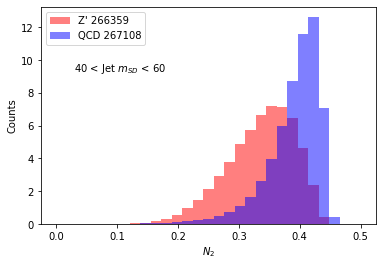

<Figure size 432x288 with 0 Axes>

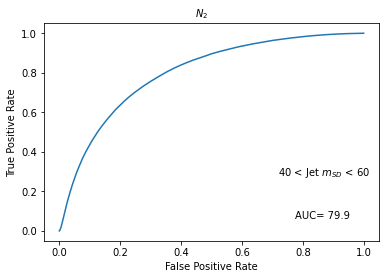

<Figure size 432x288 with 0 Axes>

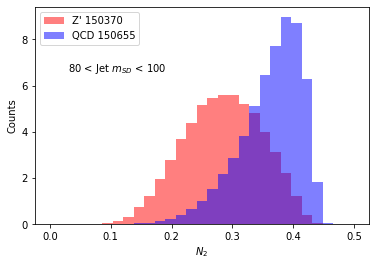

<Figure size 432x288 with 0 Axes>

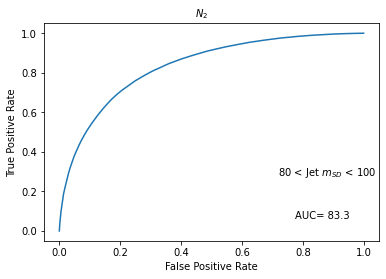

<Figure size 432x288 with 0 Axes>

In [52]:
n2_shape(40.,60.)
n2_shape(80.,100.)
#n2_shape(180.,220.)

In [15]:
class DNN(nn.Module):
    def __init__(self, n_targets):
        super(DNN, self).__init__()
        #self.flat = torch.flatten()
        self.f0 = nn.Linear(200, 400).cuda()
        self.f0b = nn.Linear(400, 400).cuda()
        self.f1 = nn.Linear(400, 100).cuda()
        self.f2 = nn.Linear(100, 50).cuda()
        self.f3 = nn.Linear(50, 10).cuda()
        self.f4 = nn.Linear(10, n_targets).cuda()
        self.activation = torch.nn.Sigmoid()
    def forward(self, x): 
        x = torch.flatten(x,start_dim=1)
        x = self.f0(x)
        #x = self.f0b(x)
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        x = self.f4(x)
        return(self.activation(x))


class MLP(torch.nn.Module):  # Model from utils
    def __init__(self,
                 input_size=10,
                 out_channels=1,
                 readout_activation=None,
                 name=None):
        """
         DNN Model inherits from torch.torch.nn.Module. Can be initialized with input_size: Number of features per sample.

        This is a class wrapper for a simple DNN model. Creates an instance of torch.torch.nn.Module that has 4 linear layers. Use torchsummary for details.

        Parameters
        ----------
        input_size : int=10
            The number of features to train on.
        out_channels : int=1
            The number of outputs. For binary classification we usually want one output for the "probability" 
            that a given sample is a signal event. If we want to classify samples into QCD, W, and Z, for example, we would use 3 outpute channels.
        readout_activation : Callable=None
            The activation function after the last output layer. torch.sigmoid for binary or toch.softmax for multiclass. 
            Defaults to None so that we can choose this manually outside the model itself.
        name : string=None
            Specifiy a name for the Dtorch.nn.break
        """
        super().__init__()
        self.linear = torch.nn.Linear(input_size, 64, bias=False).cuda()
        self.linear1 = torch.nn.Linear(64, 64,).cuda()
        self.linear2 = torch.nn.Linear(64, 64).cuda()
        self.batchnorm = torch.nn.BatchNorm1d(64).cuda()
        self.out = torch.nn.Linear(64, out_channels).cuda()
        # Defaults
        self.out_channels = out_channels
        self.readout_activation = readout_activation
        self.yhat_val = None
        self.yhat = None
        self.name = name

    def forward(self, x):
        x = torch.flatten(x,start_dim=1)
        x = swish(self.linear(x))
        x = self.batchnorm(x)
        x = swish(self.linear1(x))
        x = swish(self.linear2(x))
        x = self.out(x)
        if self.readout_activation is not None:
            x = self.readout_activation(x)
        return x

In [16]:
epochs = 30 # training epochs = # times we go over all the data
lr = 1e-3 # learning rate = coefficient for gradients. Affects convergence rate but also the hypothesis space (functions that can be learned)
#optim = torch.optim.Adam # Probably the best plug and play optimizer out there. Works really well for most problems. 
n_outputs=1
module0 = MLP(200,out_channels=n_outputs,readout_activation=torch.sigmoid)

##### Training Loop Barlow DNN #########

batchSize = 6000
n_epochs = 30

    

optimizer = optim.Adam(module0.parameters(), lr = lr)
loss_vals_training = np.zeros(n_epochs)
loss_std_training = np.zeros(n_epochs)
loss_vals_validation = np.zeros(n_epochs)
loss_std_validation = np.zeros(n_epochs)

acc_vals_training = np.zeros(n_epochs)
acc_vals_validation = np.zeros(n_epochs)
acc_std_training = np.zeros(n_epochs)
acc_std_validation = np.zeros(n_epochs)

bce_criterion = torch.nn.BCELoss()
mode0_loss = mode0

final_epoch = 0
l_val_best = 99999

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
softmax = torch.nn.Softmax(dim=1)
import time
from tqdm import tqdm 

for m in range(n_epochs):
    print("Epoch %s\n" % m)
    torch.cuda.empty_cache()
    final_epoch = m
    lst = []
    loss_val = []
    loss_training = []
    correct = []
    tic = time.perf_counter()
    
    #particleTrainingDataSig, jetMassTrainingDataSig = sklearn.utils.shuffle(particleTrainingDataSig, jetMassTrainingDataSig)
    #particleTrainingDataBkg, jetMassTrainingDataBkg = sklearn.utils.shuffle(particleTrainingDataBkg, jetMassTrainingDataBkg)
    #particleValidationDataSig, jetMassValidationDataSig = sklearn.utils.shuffle(particleValidationDataSig,
    #                                                                            jetMassValidationDataSig)
    #particleValidationDataBkg, jetMassValidationDataBkg = sklearn.utils.shuffle(particleValidationDataBkg,
    #                                                                            jetMassValidationDataBkg)
    
    particleTrainingData, trainingLabels, jetMassTrainingData = sklearn.utils.shuffle(particleTrainingData, trainingLabels, jetMassTrainingData)
    #print(particleTrainingData[:100,:,:])
    #print(trainingLabels[:100,0])
    #print(jetMassTrainingData[:100])
    #print(out1_tot)
    for i in tqdm(range(int(0.8*datapoints/batchSize))): 
        #print('%s out of %s'%(i, int(particleTrainingData.shape[0]/batchSize)))
        optimizer.zero_grad()
        #print(training_inputs)

        t_input = torch.Tensor(particleTrainingData[i*batchSize:(i+1)*batchSize]).cuda()
        y_truth = torch.Tensor(trainingLabels      [i*batchSize:(i+1)*batchSize,0]).cuda()
        m_train = torch.Tensor(jetMassTrainingData [i*batchSize:(i+1)*batchSize]).cuda()
        y_hat = module0(t_input).flatten()
        #print(y_hat.cpu().detach().numpy())
        l = bce_criterion(y_hat,y_truth)
        l += weightMode*mode0_loss(y_hat,y_truth,m_train)
        #print(l.item())
        loss_training.append(l.item())
        l.backward()
        optimizer.step()
        loss_string = "Loss: %s" % "{0:.9f}".format(l.item())

        del t_input, y_truth, m_train, l
        torch.cuda.empty_cache()
    #trainingv1_mass_tot = np.array(trainingv1_mass_tot)       
    toc = time.perf_counter()
    print(f"Training done in {toc - tic:0.4f} seconds")
    tic = time.perf_counter()


    
    
    for i in range(int(0.1*datapoints/(batchSize))): 
        v_input = torch.Tensor(particleValidationData[i*batchSize:(i+1)*batchSize]).cuda()
        v_y_truth = torch.Tensor(validationLabels[i*batchSize:(i+1)*batchSize,0]).cuda()
        v_m = torch.Tensor(jetMassValidationData[i*batchSize:(i+1)*batchSize]).flatten().cuda()
        y_hat = module0(v_input)
        l = mode0(y_hat,v_y_truth, v_m)
        loss_val.append(l.item())
        #lst.append(out.cpu().data.numpy())

        
    torch.cuda.empty_cache()
    plt.clf()

    
    toc = time.perf_counter()
    print(f"Evaluation done in {toc - tic:0.4f} seconds")
    l_val = np.mean(np.array(loss_val))

    #predicted = np.concatenate(lst) #(torch.FloatTensor(np.concatenate(lst))).to(device)
    #print('\nValidation Loss: ', l_val)

    l_training = np.mean(np.array(loss_training))
    print('Training Loss: ', l_training)
    #val_targetv = np.concatenate(correct) #torch.FloatTensor(np.array(correct)).cuda()

    torch.save(module0.state_dict(), '%s/DNN_%s_last.pth'%(outdir,label))
    if l_val < l_val_best:
        print("new best model")
        l_val_best = l_val
        torch.save(module0.state_dict(), '%s/DNN_%s_best.pth'%(outdir,label))

    #acc_vals_validation[m] = accuracy_score(val_targetv[:,0],predicted[:,0]>0.5)
    print("Validation Accuracy: ", acc_vals_validation[m])
    loss_vals_training[m] = l_training
    loss_vals_validation[m] = l_val
    loss_std_validation[m] = np.std(np.array(loss_val))
    loss_std_training[m] = np.std(np.array(loss_training))
    torch.cuda.empty_cache()

    if m > 8 and all(loss_vals_validation[max(0, m - 8):m] > min(np.append(loss_vals_validation[0:max(0, m - 8)], 200))):
        print('Early Stopping...')
        print(loss_vals_training, '\n', np.diff(loss_vals_training))
        break
    torch.cuda.empty_cache()

print('DONE with DNN training')


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score


x_torch=torch.load(f"{outdir}/{label}_particleTrainingData.pt").cuda()
y_torch=torch.load(f"{outdir}/{label}_trainingLabels.pt").cuda()
m_torch=torch.load(f"{outdir}/{label}_jetMassTrainingData.pt").cuda()

with torch.no_grad():
    module0.cuda().eval()
    outputs = module0(x_torch) # the outputs aren't properly normalized which is why we use sigmoid here
    #data_scores = torch.sigmoid(module0(torch.from_numpy(data_samples))).numpy().flatten()
    
outputs  = outputs.cpu().detach().numpy()
y_torch = y_torch.cpu().detach().numpy()
m_torch = m_torch.cpu().detach().numpy()

fig, ax=plt.subplots()
ax.hist(outputs[y_torch[:,1]==1][:,0],color="r",bins=np.linspace(0.,1.,25),alpha=0.5,label="QCD")
ax.hist(outputs[y_torch[:,1]==0][:,0],color="b",bins=np.linspace(0.,1.,25),alpha=0.5,label="Z'")
plt.legend(loc="best")
ax.set_xlabel("Discriminator")
ax.set_ylabel("Counts")
ax.text(0.45,1.03,loss_text, transform=ax.transAxes)
plt.savefig(outdir+"/discriminatorHist.png")
plt.show()

fig, ax=plt.subplots()
#print(outputs[:,0].cpu().detach().numpy(),y_torch[:,0].cpu().detach().numpy().astype(bool))
fpr, tpr, _ = roc_curve(y_torch[:,0],outputs[:,0],)
ax.plot(fpr, tpr)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.text(0.45,1.03,loss_text, transform=ax.transAxes)
ax.text(0.75,0.10, f"AUC={roc_auc_score(y_torch[:,0],outputs[:,0]) : 0.2f}", transform=ax.transAxes)
plt.savefig(outdir+"/roc.png")
np.savez(outdir+"roc.npz",fpr=fpr,tpr=tpr)
plt.show()
plt.clf()

# Calculate mass distribution after cuts

hist, edges = np.histogram(outputs[y_torch[:,1]==1][:,0], bins=np.linspace(0.,1.,100),density=True)
cdf = np.cumsum(hist)*(edges[1]-edges[0])
print(cdf)

pctls = [0.,0.25,0.5,0.7,0.9,0.95,0.99]
cuts = np.searchsorted(cdf,pctls)

fig, ax=plt.subplots()

qcd_idxs = y_torch[:,1]==1
qcd_inclusive, _ = np.histogram(
        m_torch[(qcd_idxs)],
        density=True,
    )
for c,p in zip(cuts,pctls):
    passing_idxs = outputs[:,0] > edges[c]
    hist, bin_edges = np.histogram(
        m_torch[(qcd_idxs&passing_idxs)], 
    )
    N_passing = float(np.sum(hist))
    qcd_passing = np.divide(hist,[N_passing])
    jsd = scipy.spatial.distance.jensenshannon(qcd_passing, qcd_inclusive)

    bins_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    ax.plot(
        bins_centers, 
        qcd_passing,
        label = f"{(1-p)*100:.0f}% ({int(N_passing)}) JSD={0 if jsd == np.nan else jsd:.2f}"
    )
ax.set_xlabel("Jet mass (GeV)")
ax.set_ylabel("a.u.")
plt.legend(loc="best")
ax.text(0.05,1.03,"QCD jets", transform=ax.transAxes)
ax.text(0.45,1.03,loss_text, transform=ax.transAxes)
plt.savefig(outdir+"/sculptingQCD.png")
plt.show()
print(cuts)

plt.clf()
fig, ax=plt.subplots()
ax.hist2d(outputs[y_torch[:,1]==1][:,0],m_torch[y_torch[:,1]==1],bins=20)
#ax.plot(m_torch.cpu().detach().numpy(),outputs[:,1].cpu().detach().numpy(),color="b",label="Z'")
plt.legend(loc="best")
ax.set_ylabel("Jet mass (GeV)")
ax.set_xlabel("Discriminator")
ax.text(0.05,1.03,"QCD jets", transform=ax.transAxes)
ax.text(0.45,1.03,loss_text, transform=ax.transAxes)
plt.savefig(outdir+"/discriminatorvsMassQCD.png")
plt.show()

del y_torch, m_torch, outputs, outputs_optimal_clr
torch.cuda.empty_cache()

In [ ]:
os.system(f"rm {outdir}/{label}_particleTrainingData.pt")
os.system(f"rm {outdir}/{label}_jetMassTrainingData.pt")
os.system(f"rm {outdir}/{label}_trainingLabels.pt")